In [1]:
import numpy as np
import tensorflow as tf
import string
import pandas as pd
from gensim.models import KeyedVectors
import spacy
from unidecode import unidecode
import model_utils
import constants
import os

In [2]:
word2vec = KeyedVectors.load("./../word2vec/word2vec_100_3_polish.bin")

In [3]:
def tokens_to_vector(sentence):
    vector_size = word2vec.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sentence:
        if w in word2vec:
            ctr += 1
            wv_res += word2vec[w]
    wv_res = wv_res/ctr
    return wv_res

In [4]:
spacy_model = spacy.load("pl_core_news_sm")

In [5]:
# Stop words
stop_words = spacy_model.Defaults.stop_words.copy()
stop_words.remove("nie")
print(stop_words)

{'cos', 'cała', 'twoje', 'niego', 'moim', 'przeciez', 'jaki', 'można', 'aż', 'gdy', 'ktorych', 'teraz', 'mogą', 'iz', 'im', 'o', 'czemu', 'dziś', 'którym', 'ktore', 'jeden', 'powinno', 'której', 'ktorym', 'bym', 'mało', 'ktos', 'nasi', 'twym', 'niemu', 'nic', 'pod', 'zaś', 'było', 'kazdy', 'sposob', 'chce', 'pana', 'dosc', 'z', 'kiedy', 'tys', 'bo', 'cały', 'gdzie', 'żadna', 'jakichś', 'dokad', 'byla', 'moga', 'az', 'nasze', 'których', 'natomiast', 'tak', 'swoje', 'one', 'być', 'ponad', 'nim', 'oni', 'przede', 'was', 'jesli', 'wtedy', 'toba', 'był', 'bowiem', 'sobie', 'do', 'bede', 'jakis', 'oraz', 'cali', 'ktora', 'ktorej', 'były', 'byli', 'jakkolwiek', 'mam', 'vi', 'jakiś', 'inny', 'lub', 'duzo', 'przecież', 'wy', 'miał', 'miedzy', 'niż', 'sobą', 'xiv', 'więc', 'beda', 'która', 'nad', 'tylko', 'tego', 'moj', 'ponieważ', 'inna', 'jedynie', 'bedzie', 'ja', 'cię', 'zadnych', 'nią', 'będą', 'co', 'razie', 'gdzies', 'skad', 'które', 'żeby', 'ale', 'na', 'zadne', 'zapewne', 'w', 'jest', 'k

In [6]:
len(stop_words)

380

In [7]:
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [8]:
# Tokenizer
def spacy_tokenizer(sentence):
    doc = spacy_model(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in doc ]

    # Removing stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [9]:
df = pd.read_json('../../data/translated/emotions/equalized_emotions_dataset_pl.json')
df = df.drop(columns=['text'])
df

,emotions,text_pl
0,anger,Czuję się całkowicie chciwy
1,fear,Czuję się tak przytłoczony emocjami
2,surprise,Nie czułem efektu siły g Jestem oszołomiony Po...
3,anger,ive just got to tell you all that I feel Racze...
4,anger,"Powiedziałem ci, że przepraszam, że czujesz si..."
...,...,...
39995,joy,"czuję się ostatnio dość hojny, ponieważ pracuj..."
39996,love,"Czuję, że niektóre postacie nie zasługują na w..."
39997,fear,"Czuję strach w moich kościach, którego nie moż..."
39998,joy,Czułem się bardziej kreatywny i mniej jak czys...


In [11]:
df['text_pl'] = df['text_pl'].apply(unidecode)

In [12]:
df['tokens'] = df['text_pl'].apply(spacy_tokenizer)
df.to_json(r'./utils/tokenized_dataset_no_diacritics.json')

In [14]:
tokenized_sentences_df = pd.read_json('./utils/tokenized_dataset_no_diacritics.json')

In [15]:
ordered_class_labels = {
    "joy": 0,
    "love": 1,
    "surprise": 2,
    "sadness": 3,
    "anger": 4,
    "fear": 5,
}

In [20]:
tokenized_sentences_df = tokenized_sentences_df.replace({"emotions": ordered_class_labels})

In [21]:
tokenized_sentences = tokenized_sentences_df['tokens'].values.tolist()
emotions_labels = tokenized_sentences_df['emotions'].values.tolist()

In [22]:
vectors = [tokens_to_vector(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

In [23]:
X = np.array(vectors)
Y = np.array(emotions_labels)

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, train_size=0.5, random_state=42)

In [25]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(6, activation='sigmoid'))

In [26]:
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [27]:
# Model parameters
training_number = 1
model_name = 'emotions_pl_word2vec_external_no_diacritics'
training_name = model_name
figures_dir = f"../../documentation/models/{model_name}/figures"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)
batch_size = 32

In [28]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [29]:
history = model.fit(x=X_train, y=Y_train, validation_data=(X_val, Y_val), epochs=20, batch_size=batch_size, callbacks=[checkpoint_cb, early_stop_cb])

Epoch 1/20
 984/1000 [============================>.] - ETA: 0s - loss: 1.5698 - accuracy: 0.3589
Epoch 1: saving model to ../../training_checkpoints\emotions_pl_word2vec_external_no_diacritics\emotions_pl_word2vec_external_no_diacritics\cp-0001.ckpt
1000/1000 [==============================] - 4s 4ms/step - loss: 1.5685 - accuracy: 0.3598 - val_loss: 1.4653 - val_accuracy: 0.4117
Epoch 2/20
 989/1000 [============================>.] - ETA: 0s - loss: 1.4369 - accuracy: 0.4347
Epoch 2: saving model to ../../training_checkpoints\emotions_pl_word2vec_external_no_diacritics\emotions_pl_word2vec_external_no_diacritics\cp-0002.ckpt
1000/1000 [==============================] - 3s 3ms/step - loss: 1.4366 - accuracy: 0.4348 - val_loss: 1.4302 - val_accuracy: 0.4350
Epoch 3/20
 985/1000 [============================>.] - ETA: 0s - loss: 1.3751 - accuracy: 0.4639
Epoch 3: saving model to ../../training_checkpoints\emotions_pl_word2vec_external_no_diacritics\emotions_pl_word2vec_external_no_diacr

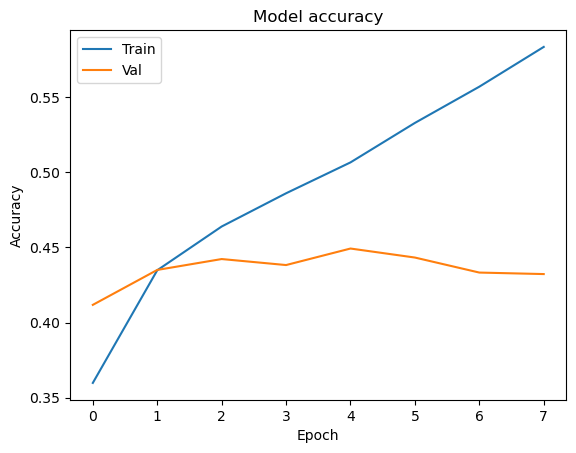

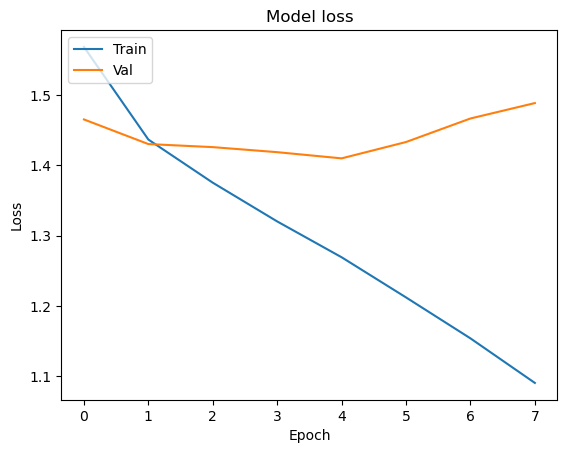

In [30]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [31]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

125/125 [==============================] - 0s 1ms/step


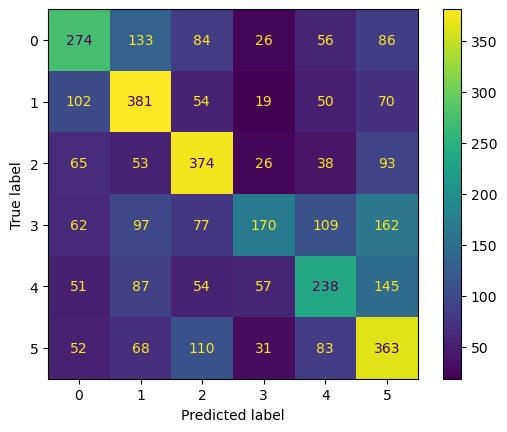

In [32]:
class_preds = model_utils.get_class_preds(best_model, X_test, model_returns_logits=False)
model_utils. plot_and_save_conf_matrix(class_actual=Y_test,
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [33]:
# Evaluation
best_model.evaluate(X_test, Y_test, batch_size=batch_size)

125/125 [==============================] - 0s 2ms/step - loss: 1.4016 - accuracy: 0.4500


[1.401607871055603, 0.44999998807907104]

In [34]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number,
                       saved_models_dir=constants.SAVED_MODEL_LOCATION,
                       default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ../../trained_models\emotions_pl_word2vec_external_no_diacritics_1\1\assets
